In [1]:
import os
from dask.distributed import progress,wait,Client, LocalCluster
import dask.array as da
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import rioxarray
import random
from time import time

from numba import jit

from sklearn.cluster import MiniBatchKMeans
from dask_ml.wrappers import Incremental
from dask_ml.wrappers import ParallelPostFit
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans

ncores = multiprocessing.cpu_count()
ncores

# launch a scheduler and workers locally
cluster = LocalCluster()

# connect to cluster
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 31.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43845,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.21 GiB
Comm: tcp://127.0.0.1:34167,Total threads: 4
Dashboard: http://127.0.0.1:38047/status,Memory: 5.20 GiB
Nanny: tcp://127.0.0.1:36013,


In [2]:
# path and sitename
site = 'TALL'
data = '/media/data/NEON/TALL/hyperspectral/DP3.30006.001/2021/FullSite/D08/2021_TALL_6/L3/Spectrometer/Reflectance'

# find the filenames, picj example file
files = [os.path.join(data, f) for f in os.listdir(data) if '.nc' in f and site in f]

In [3]:
h = xr.open_mfdataset(files)

In [4]:
h

<xarray.Dataset>
Dimensions:      (x: 7000, y: 7000, wl: 358)
Coordinates:
  * x            (x) float64 4.6e+05 4.6e+05 4.6e+05 ... 4.67e+05 4.67e+05
  * y            (y) float64 3.642e+06 3.642e+06 ... 3.649e+06 3.649e+06
  * wl           (wl) float32 381.7 386.7 391.7 ... 2.506e+03 2.511e+03
Data variables:
    reflectance  (x, y, wl) int16 dask.array<chunksize=(1000, 1000, 358), meta=np.ndarray>
    spatial_ref  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    scale_factor:   10000.0
    no_data_value:  -9999.0

In [7]:
# generate indices to randomply sample pixels
size = 1/25
xs = random.sample(range(h.x.shape[0]), int(h.x.shape[0] * size))
ys = random.sample(range(h.y.shape[0]), int(h.y.shape[0] * size))
xs.sort()

# get wl dimension size
wl_len = h.wl.values.shape[0]

print('extract')
# extract the sample and switch to numpy
h_ = np.array(h.isel(x=xs, y=ys).reflectance.data)

print('reshape')
# reshape from 3d (x,y,wl) to 2d (x*y,wl)
@jit
def resh(arr, dim):
    arr = arr.reshape(-1, dim)
    return arr

h_ = resh(h_, wl_len)

print('drop')
# drop nulls
h_ = h_[(~da.any(h_ == -9999, axis=1)) & (~da.any(da.isnan(h_), axis=1))]

#print('redask')
# return to dask array
#h_ = da.from_array(h_, chunks=(1000, -1))


extract


/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


reshape
drop


In [9]:
h_.shape

(71396, 358)

# PCA

Now we will perform PCA, first we need to compute the covariance matrix, its eigenvalues, and its eigenvectors.

In [11]:
covariance_matrix=np.cov(h_.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

Then we will make ordered copies of the eigen things sorted by eigen values.  This will place teh eigen value and vector with the most information content at the top of the list

In [19]:
# make an index list
idx = np.arange(0, len(eigen_values), 1)

# sort the idx list based on the order of eigen_values
idx = [i for _, i in sorted(zip(eigen_values, idx))]

# reverse the order of idx
idx = idx[::-1]

# make a copy of the eigen vlues and vectors sorted by values
eigen_values1 = eigen_values[idx]
eigen_vectors1 = eigen_vectors[:,idx]


Now lets plot the eigen values to get an idea how many principal components we should use.  

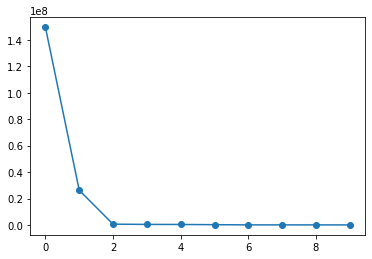

In [21]:
x = np.arange(0, len(eigen_values1[:10]), 1)
plt.plot(x, eigen_values1[:10], marker = 'o');

The 

In [6]:
# restart client to avoid worker issues
client.restart()

# scale the data
scaler = StandardScaler().fit(h_)
d_train = scaler.transform(h_)
print(f'There are {d_train.shape[0]} records in the "fit" data spread over {d_train.npartitions} partitions.')


There are 71847 records in the "fit" data spread over 72 partitions.


In [7]:
n_clusters = 8

print('estimator')
# define the estimator
est = KMeans(n_clusters=n_clusters, oversampling_factor=10)

print('fit')
# fit the model and time
t = time()
k = est.fit(d_train)
print(f'That took: {round((time() - t) / 60.0, 2)} minutes')

estimator
fit


Exception in thread Profile:
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 115, in process
    d = state["children"][ident]
KeyError: 'transition_generic_released;/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/worker.py;2147'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 274, in _watch
    process(frame, None, recent, omit=omit)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 119, in process
    "descriptio

That took: 1.25 minutes


In [46]:
# break the full dset into tiles

# make tile indices
step = 500
xrange = range(int(h.x.values.min()), int(h.x.values.max()), step)

yrange = range(int(h.y.values.min()), int(h.y.values.max()), step)

# get wl dimension size
wl_len = h.wl.values.shape[0]

# iterate through
for i, x in enumerate(xrange[:1]):
    for j, y in enumerate(yrange[:1]):
        
        # make masks
        maskx = (h.x >= x ) & (h.x < x + step + 1.5 * int(i == len(xrange) - 1))
        masky = (h.y >= y ) & (h.y < y + step + 1.5 * int(j == len(yrange) - 1))
        
        # extract the sample
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            h_ = h.isel(x=maskx, y=masky).reflectance.data

        # remember the shape
        sh = h_.shape

        # reshape from 3d (x,y,wl) to 2d (x*y,wl)
        h_ = resh(h_, wl_len)

        # drop nulls
        h_ = h_[(~da.any(h_ == -9999, axis=1)) & (~da.any(da.isnan(h_), axis=1))]

        # reshape full data from 3d (x,y,wl) to 2d (x*y,wl)
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            d_final = h.reflectance.data.reshape((-1, sh[2])).rechunk(('auto', -1))
            
        # transform full data with the previously fitted scaler
        d_final = scaler.transform(d_final)
        
        # cluster
        d_kmeans = k.predict(d_final).reshape(sh[0:2])
        wait(d_kmeans)
        print(f'''It took: {round((time() - t) / 60.0, 2)}
        minutes to classify that {step}x{step} tile''')
        
        # add clustered array back into xarray
        h_['cluster'] =  d_kmeans


KeyboardInterrupt



In [ ]:
# predict the cluster for full data, transform back to 3d (x,y,wl)
t = time()
d_kmeans = k.predict(d_final).persist().reshape(h.reflectance.shape[0:2])
wait(d_kmeans)
print(f'That took: {round((time() - t) / 60.0, 2)} minutes')

In [14]:
d_kmeans

NameError: name 'd_kmeans' is not defined

In [17]:
kmeans = xr.DataArray(data=d_kmeans,
                      coords={'x': h.coords['x'].values,
                              'y': h.coords['y'].values},
                      dims=('y', 'x')).to_dataset(name='kmean_clust')

In [ ]:
# plot  at a 1/(10*10) resolution
plt.figure(figsize=(16,12))
kmeans.isel(x=slice(None,None,10),y=slice(None,None,10)).kmean_clust.plot()